# Assignment 1 2AMM10 2023-2024

## Group: [Group 6]
### Member 1: [Luca Mainardi]
### Member 2: [Francesco Brescia]
### Member 3: [Matthew Nana]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_dir = '/content/drive/MyDrive/Assignment 1/'

In [3]:
main_dir=''

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
# Variable to enable/disable training
TRAIN_TRIPLET = True
TRAIN_TRIPLET_ROTATION = True

In [5]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [6]:
train_data = load_data(main_dir + 'data/train_data.pkl')

In [7]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [8]:
len(alphabets)

30

In [9]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 640x480 with 0 Axes>

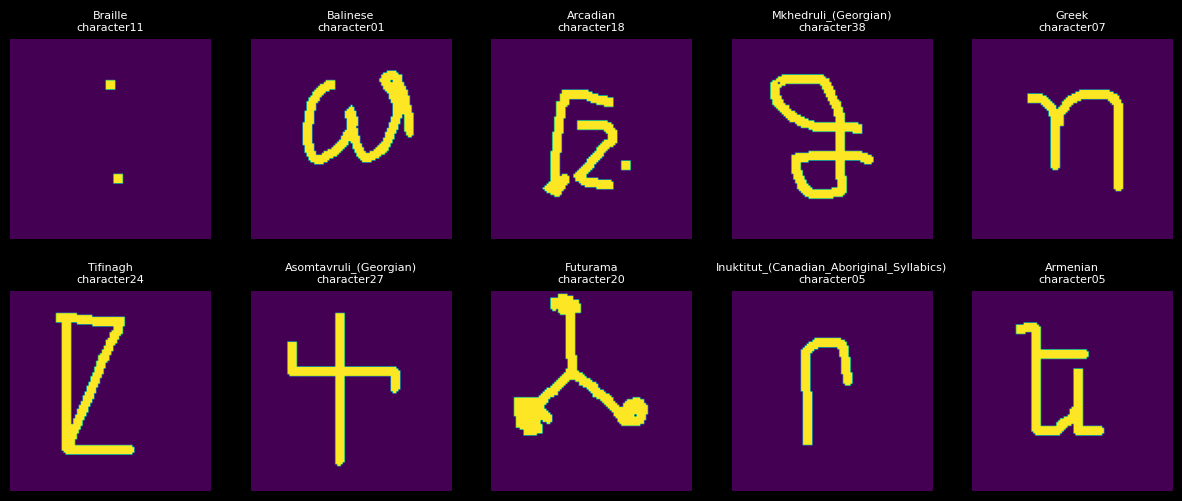

In [10]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torch.utils.data import random_split
from sklearn.preprocessing import LabelEncoder

In [12]:
# DO NOT REMOVE OR MODIFY
# Check if GPU is available and determine the device
if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.cuda.manual_seed_all(42)
else:
    DEVICE = 'cpu'

print(f'The available device is {DEVICE}')

The available device is cuda


## Triplet Network

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        positive_distance = (output1 - output2).pow(2).sum(1)
        negative_distance = (output1 - output3).pow(2).sum(1)
        losses = torch.relu(positive_distance - negative_distance + self.margin)
        return losses.mean()

In [14]:
class Lambda(nn.Module):
    """
    A utility class that allows you to create a PyTorch nn.Module from an arbitrary function.
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    """
    A PyTorch implementation of a Convolutional Neural Network (CNN) for feature extraction or embedding.

    The network consists of three convolutional blocks each followed by a batch normalization, ReLU activation, and max pooling.
    After the convolutional blocks, the tensor is flattened and passed through two fully connected (linear) layers.

    The final output is a 10-dimensional vector which can be used as an embedding of the input.
    """
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TripletNet(nn.Module):
    """
    A PyTorch implementation of a Triplet Network for learning useful data embeddings.

    The network takes three inputs - an anchor, a positive of the same class as the anchor, and a negative of a different class.
    Each of these inputs is passed through the same embedding network, and the output embeddings are returned.

    The goal during training is to learn an embedding such that the distance between the anchor and positive is less than the distance between the anchor and negative.
    """
    def __init__(self, embedding_net):
        """Initializes the TripletNet with the given embedding network."""
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        """Forward pass for the TripletNet."""
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        """Returns the embeddings of the input."""
        return self.embedding_net(x)


class TripletDataset(Dataset):
    """
    A custom dataset class for creating triplets of images with their corresponding labels.

    Args:
        data_dict (dict): A dictionary containing the image data organized by alphabet and character.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.

    Attributes:
        images (list): A list of all the images in the dataset.
        labels (list): A list of labels corresponding to each image.
        transform (callable): The transform function to be applied to the images.
        encoder (LabelEncoder): An instance of the LabelEncoder class for encoding the labels.
        triplets (list): A list of triplets of images with the anchor, positive and negative images.
    """
    def __init__(self, data_dict, transform=None, device=DEVICE):

        np.random.seed(42)

        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

        # Create list with triplets of images, where the first two images are similar and the third is different
        # Consider all the pairs of positive images and sample two negative images for each pair
        self.triplets = []

        for i in tqdm(range(len(self.images))):
            for j in range(i+1, len(self.images)):
                if self.labels[i] == self.labels[j]:
                    for _ in range(2):
                        # sample the third image
                        index = np.random.choice(len(self.images))
                        # If the third image is from the same class, sample another one
                        while self.labels[index] == self.labels[i]:
                            index = np.random.choice(len(self.images))
                        self.triplets.append((self.images[i], self.images[j], self.images[index]))



    def __len__(self):
        """
        Returns the total number of triplets in the dataset.
        """
        return len(self.triplets)

    def __getitem__(self, idx):
        """
        Returns the triplet of images at the given index.
        """
        img1, img2, img3 = self.triplets[idx]

        if self.transform:
            to_pil = transforms.ToPILImage()
            img1 = to_pil(img1)
            img1 = self.transform(img1)
            img2 = to_pil(img2)
            img2 = self.transform(img2)
            img3 = to_pil(img3)
            img3 = self.transform(img3)

        return img1, img2, img3

# Function to create Triplet dataset
def create_triplet_dataset(data_dict, transform=None):
    """
    Creates a Triplet dataset from the given data dictionary.
    """
    return TripletDataset(data_dict=data_dict, transform=transform)

# Function to train Triplet network
def train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=DEVICE):
    """
    Trains a triplet network for a specified number of epochs.

    The function takes as input a triplet network, training and validation data loaders, number of epochs, and learning rate.
    It uses the Adam optimizer and a custom TripletLoss criterion.
    For each epoch, it iterates over the training data, computes the loss and backpropagates the gradients.
    It also computes the AUC-ROC for each batch and keeps a running total.
    After each epoch, it evaluates the network on the validation data and computes the average loss and AUC-ROC.

    Parameters:
    triplet_network (nn.Module): The triplet network to train.
    train_loader (DataLoader): The DataLoader for the training data.
    val_loader (DataLoader): The DataLoader for the validation data.
    num_epochs (int, optional): The number of epochs to train for. Default is 10.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    None
    """
    criterion = TripletLoss().to(device)
    optimizer = optim.Adam(triplet_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        triplet_network.train()

        running_loss = 0.0
        running_distance = 0.0
        batch_count = 0

        for img1, img2, img3 in progress_bar:
            optimizer.zero_grad()
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
            output1, output2, output3 = triplet_network(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
            running_distance += distance
            batch_count += 1

            # Update the progress bar with the current loss and distance
            progress_bar.set_postfix({"loss": running_loss / batch_count, "distance": running_distance / batch_count})

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Distance: {running_distance/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        triplet_network.eval()
        running_val_loss = 0.0
        running_val_distance = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, img3 in progress_bar:
                img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
                output1, output2, output3 = triplet_network(img1, img2, img3)
                val_loss = criterion(output1, output2, output3)
                running_val_loss += val_loss.item()
                val_distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
                running_val_distance += val_distance
                batch_count += 1

                # Update the progress bar with the current loss and distance
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_distance": running_val_distance / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Distance: {running_val_distance/len(val_loader)}")


# Function to compute distance of the Triplet network
def compute_distance_triplet(output1, output2, output3):
    """
    Computes the Distance for a triplet.

    The function takes as input the output embeddings of an anchor, positive, and negative example from a triplet network.
    It computes the Euclidean distance between the anchor and positive examples (distance_positive) and between the anchor and negative examples (distance_negative).
    It performs the difference and infince the average per batch.

    Parameters:
    output1 (torch.Tensor): The output embedding of the anchor example.
    output2 (torch.Tensor): The output embedding of the positive example.
    output3 (torch.Tensor): The output embedding of the negative example.

    Returns:
    float: The distance.
    """
    # Compute the Euclidean distance between output1 and output2 and between output1 and output3
    distance_positive = (output1 - output2).pow(2).sum(1).sqrt()
    distance_negative = (output1 - output3).pow(2).sum(1).sqrt()

    return (distance_negative - distance_positive).cpu().numpy().mean()

In [15]:
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),
    transforms.Grayscale(num_output_channels=1)
])

In [16]:
# Create Triplet network
triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)

In [17]:
#  Create Triplet dataset
triplet_dataset = create_triplet_dataset(train_data, transform=preprocess)

# Define the size of the validation set
val_size = int(0.2 * len(triplet_dataset))  # 20% of the dataset
train_size = len(triplet_dataset) - val_size

# Create train and validation sets
generator = torch.Generator().manual_seed(42)
triplet_train_dataset, triplet_val_dataset = random_split(triplet_dataset, [train_size, val_size], generator=generator)

# Create data loaders
train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(triplet_val_dataset, batch_size=32, shuffle=False)

print(f"Num of training triplets: {len(triplet_train_dataset)}")
print(f"Num of validation triplets: {len(triplet_val_dataset)}")

  0%|          | 0/19280 [00:00<?, ?it/s]

100%|██████████| 19280/19280 [00:55<00:00, 347.23it/s] 

Num of training triplets: 293056
Num of validation triplets: 73264


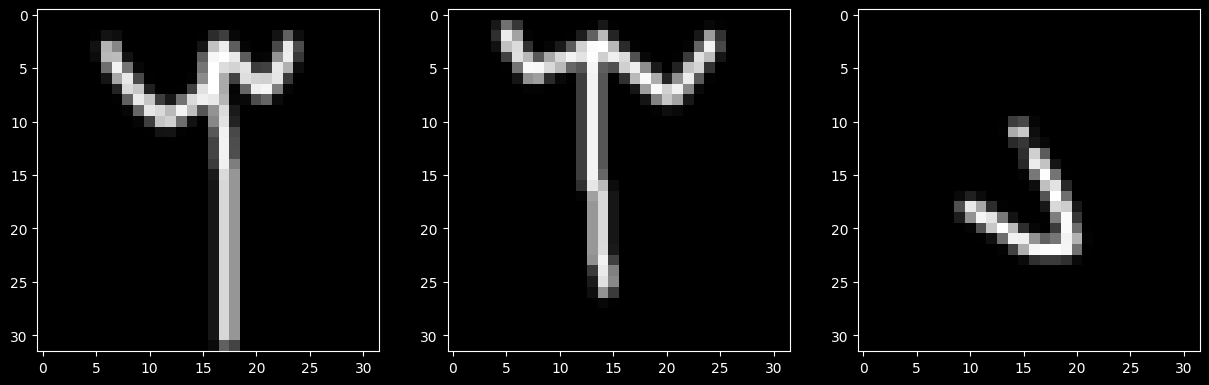

In [18]:
def plot_image(img):
    if img.shape[0] == 1:
        # Grayscale image
        plt.imshow(img.squeeze(0), cmap='gray')
    else:
        # RGB image
        plt.imshow(img.permute(1, 2, 0))

# Plot some random pairs of images from the validation set
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(len(triplet_val_dataset))
img1, img2, img3 = triplet_val_dataset[random_idx]
plt.subplot(1, 3, 1)
plot_image(img1)
plt.subplot(1, 3, 2)
plot_image(img2)
plt.subplot(1, 3, 3)
plot_image(img3)

In [18]:
# Train the Triplet network
if TRAIN_TRIPLET:
    train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=5, learning_rate=0.001)
    # Save the trained Siamese network
    torch.save(triplet_network.state_dict(), main_dir + 'triplet_network.pth')

Epoch 1:   0%|          | 0/9158 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 9158/9158 [15:29<00:00,  9.86it/s, loss=0.205, distance=2.53]


Epoch 1, Loss: 0.20458758111614397, Distance: 2.529618296904445


Val Epoch 1: 100%|██████████| 2290/2290 [02:21<00:00, 16.17it/s, val_loss=0.109, val_distance=2.6] 


Val Epoch 1, Loss: 0.10916982685179169, Distance: 2.597807748765404


Epoch 2: 100%|██████████| 9158/9158 [15:13<00:00, 10.03it/s, loss=0.08, distance=3.02]  


Epoch 2, Loss: 0.07999841376144921, Distance: 3.024855824765432


Val Epoch 2: 100%|██████████| 2290/2290 [02:16<00:00, 16.75it/s, val_loss=0.0545, val_distance=3.09]


Val Epoch 2, Loss: 0.05451313232653266, Distance: 3.0895079236884304


Epoch 3: 100%|██████████| 9158/9158 [15:17<00:00,  9.98it/s, loss=0.0546, distance=3.26]


Epoch 3, Loss: 0.05456995242015975, Distance: 3.2607130323025983


Val Epoch 3: 100%|██████████| 2290/2290 [02:16<00:00, 16.78it/s, val_loss=0.0605, val_distance=3.53]


Val Epoch 3, Loss: 0.06046362428490772, Distance: 3.529392257111562


Epoch 4: 100%|██████████| 9158/9158 [15:12<00:00, 10.04it/s, loss=0.0426, distance=3.45]


Epoch 4, Loss: 0.042574625597344554, Distance: 3.4483690663544104


Val Epoch 4: 100%|██████████| 2290/2290 [02:17<00:00, 16.61it/s, val_loss=0.0424, val_distance=3.42]


Val Epoch 4, Loss: 0.04241544792843437, Distance: 3.4240738784381914


Epoch 5: 100%|██████████| 9158/9158 [15:12<00:00, 10.04it/s, loss=0.0354, distance=3.62]


Epoch 5, Loss: 0.0354091299758367, Distance: 3.6160804116587943


Val Epoch 5: 100%|██████████| 2290/2290 [02:16<00:00, 16.81it/s, val_loss=0.0409, val_distance=3.54]


Val Epoch 5, Loss: 0.040937796589719154, Distance: 3.5443049583893154


In [19]:
# Train the Triplet network
if TRAIN_TRIPLET:
    train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=5, learning_rate=0.0005)
    # Save the trained Siamese network
    torch.save(triplet_network.state_dict(), main_dir + 'triplet_network_1.pth')

Epoch 1: 100%|██████████| 9158/9158 [14:43<00:00, 10.37it/s, loss=0.019, distance=3.94] 


Epoch 1, Loss: 0.018994277027492755, Distance: 3.944126049929192


Val Epoch 1: 100%|██████████| 2290/2290 [02:10<00:00, 17.58it/s, val_loss=0.0216, val_distance=3.88]


Val Epoch 1, Loss: 0.021552348660719967, Distance: 3.8816938938532335


Epoch 2: 100%|██████████| 9158/9158 [14:44<00:00, 10.35it/s, loss=0.015, distance=4.13] 


Epoch 2, Loss: 0.015038420147030445, Distance: 4.1256101715640225


Val Epoch 2: 100%|██████████| 2290/2290 [02:09<00:00, 17.72it/s, val_loss=0.0207, val_distance=4.27]


Val Epoch 2, Loss: 0.02072705398740727, Distance: 4.2706890317550394


Epoch 3: 100%|██████████| 9158/9158 [14:45<00:00, 10.34it/s, loss=0.0133, distance=4.32]


Epoch 3, Loss: 0.013278773538141851, Distance: 4.324746114870793


Val Epoch 3: 100%|██████████| 2290/2290 [02:10<00:00, 17.60it/s, val_loss=0.0189, val_distance=4.14]


Val Epoch 3, Loss: 0.018943897556659955, Distance: 4.142739824748976


Epoch 4: 100%|██████████| 9158/9158 [14:44<00:00, 10.35it/s, loss=0.0119, distance=4.42]


Epoch 4, Loss: 0.011896122646031746, Distance: 4.419248517670208


Val Epoch 4: 100%|██████████| 2290/2290 [02:08<00:00, 17.77it/s, val_loss=0.0231, val_distance=4.75]


Val Epoch 4, Loss: 0.023148009002078567, Distance: 4.746227216095903


Epoch 5: 100%|██████████| 9158/9158 [14:44<00:00, 10.36it/s, loss=0.0112, distance=4.57] 


Epoch 5, Loss: 0.011158566974423993, Distance: 4.566918569247414


Val Epoch 5: 100%|██████████| 2290/2290 [02:08<00:00, 17.76it/s, val_loss=0.0218, val_distance=4.54]

Val Epoch 5, Loss: 0.021794235864125485, Distance: 4.536407415835618


In [20]:
# Train the Triplet network
if TRAIN_TRIPLET:
    train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=5, learning_rate=0.0001)
    # Save the trained Siamese network
    torch.save(triplet_network.state_dict(), main_dir + 'triplet_network_2.pth')

Epoch 1: 100%|██████████| 9158/9158 [14:43<00:00, 10.37it/s, loss=0.00517, distance=4.83]


Epoch 1, Loss: 0.005165534116755695, Distance: 4.828724085724908


Val Epoch 1: 100%|██████████| 2290/2290 [02:07<00:00, 18.00it/s, val_loss=0.0139, val_distance=5.05]


Val Epoch 1, Loss: 0.013851133413515238, Distance: 5.054863485290494


Epoch 2: 100%|██████████| 9158/9158 [14:43<00:00, 10.36it/s, loss=0.00295, distance=5.23]


Epoch 2, Loss: 0.0029520515086453513, Distance: 5.228052231077806


Val Epoch 2: 100%|██████████| 2290/2290 [02:10<00:00, 17.58it/s, val_loss=0.0127, val_distance=5.42]


Val Epoch 2, Loss: 0.01274729447528785, Distance: 5.41941104018532


Epoch 3: 100%|██████████| 9158/9158 [14:42<00:00, 10.38it/s, loss=0.00213, distance=5.44]


Epoch 3, Loss: 0.002127966222189144, Distance: 5.437938974736221


Val Epoch 3: 100%|██████████| 2290/2290 [02:10<00:00, 17.55it/s, val_loss=0.0129, val_distance=5.59]


Val Epoch 3, Loss: 0.012914897431517792, Distance: 5.592799243968647


Epoch 4: 100%|██████████| 9158/9158 [14:43<00:00, 10.37it/s, loss=0.00166, distance=5.75]


Epoch 4, Loss: 0.0016561932320787699, Distance: 5.749488822079351


Val Epoch 4: 100%|██████████| 2290/2290 [02:09<00:00, 17.66it/s, val_loss=0.0139, val_distance=6.06]


Val Epoch 4, Loss: 0.013905358000548646, Distance: 6.058741615328726


Epoch 5: 100%|██████████| 9158/9158 [14:43<00:00, 10.37it/s, loss=0.00161, distance=6.11] 


Epoch 5, Loss: 0.0016144504597755103, Distance: 6.11093638041676


Val Epoch 5: 100%|██████████| 2290/2290 [02:10<00:00, 17.50it/s, val_loss=0.0135, val_distance=6.19]

Val Epoch 5, Loss: 0.013460605474408537, Distance: 6.1870257163151905


In [22]:
# Load the trained Triplet Network
triplet_networks = TripletNet(EmbeddingNet()).to(DEVICE)
triplet_networks.load_state_dict(torch.load(main_dir + 'triplet_network_2.pth'))

<All keys matched successfully>

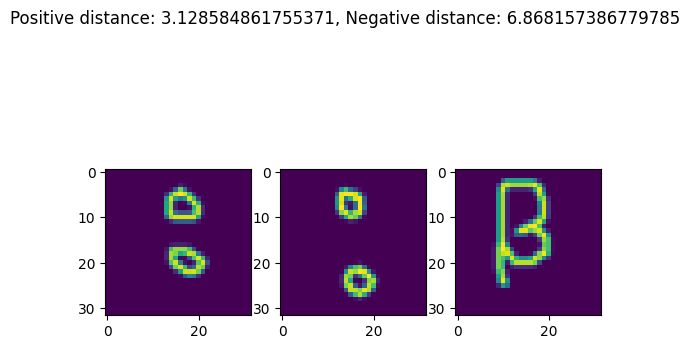

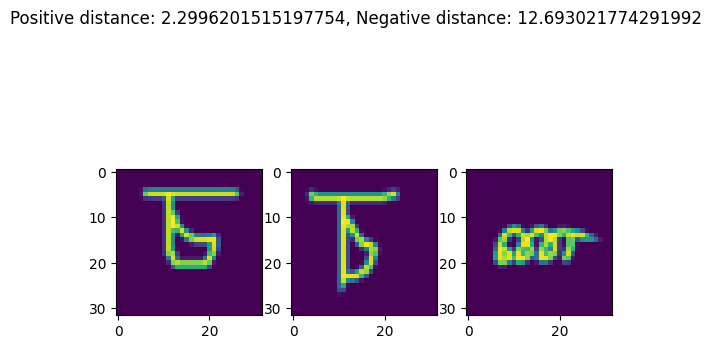

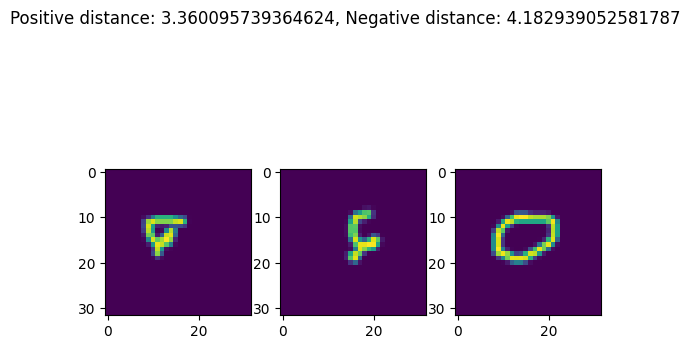

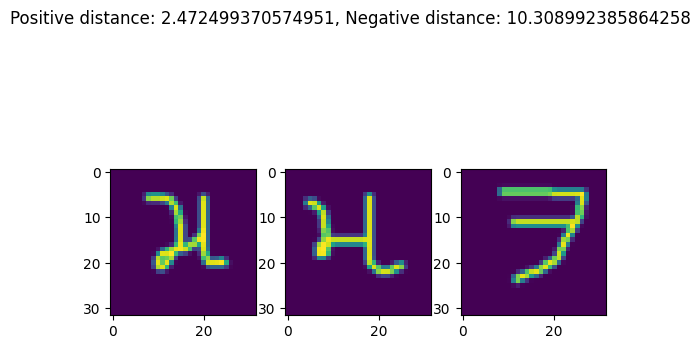

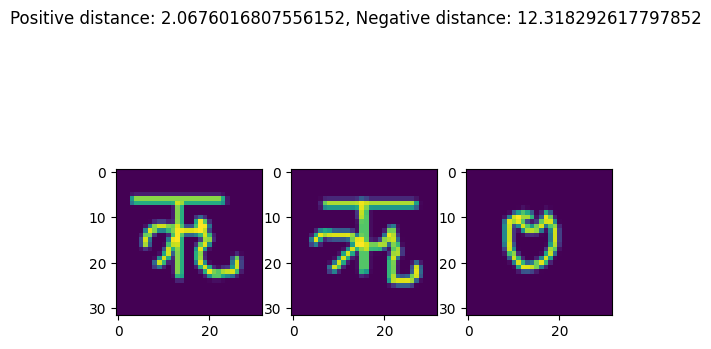

In [23]:
# Visualize predictions
import matplotlib.pyplot as plt
import random
import itertools

# Test the trained Siamese network on some random pairs of images
def visualize_predictions_triplet_network(triplet_network, val_loader, num_pairs=5, device=DEVICE):
    triplet_network.eval()
    for _ in range(num_pairs):
        # Create a new iterator for the validation loader
        dataiter = iter(val_loader)
        # Select a random batch
        batch_idx = random.randint(0, len(val_loader)-1)
        # Reset the iterator and advance to the random batch
        dataiter = itertools.islice(dataiter, batch_idx, None)
        img1, img2, img3 = next(dataiter)

        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        output1, output2, output3 = triplet_network(img1, img2, img3)

        distance_positive = (output1 - output2).pow(2).sum(1).sqrt()
        distance_negative = (output1 - output3).pow(2).sum(1).sqrt()


        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img1[0].cpu().numpy().transpose((1, 2, 0)))
        ax2.imshow(img2[0].cpu().numpy().transpose((1, 2, 0)))
        ax3.imshow(img3[0].cpu().numpy().transpose((1, 2, 0)))
        fig.suptitle(f"Positive distance: {distance_positive[0]}, Negative distance: {distance_negative[0]}")
        plt.show()

visualize_predictions_triplet_network(triplet_network, val_loader)



In [30]:
# evaluation method
def evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=True, device=DEVICE) -> float:
    """
    This function evaluates the Triplet network on the test data
    :param triplet_network: the trained Triplet network
    :param data_dict_test: the test data dictionary with the keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'
    :param K: the number of most similar images to consider
    """
    triplet_network.eval()
    correct_predictions = 0
    num_images = 0

    # Transform images
    toPILImage = transforms.ToPILImage()

    for alphabet in tqdm(data_dict_test['annotated_images'].keys()):

        correct_predictions_alphabet = 0

        for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet]):

            # compute embedding for unseen image
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)
            embedding_unseen = triplet_network.get_embedding(unseen_image.unsqueeze(0).to(device))

            # list of cosine similarities
            distances = []

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)
                embedding_unnnotated = triplet_network.get_embedding(annotated_image.unsqueeze(0).to(device))

                distance = (embedding_unseen - embedding_unnnotated).pow(2).sum(1).sqrt()
                distances.append(distance.item())

            # Get the indices of the K smallest distances
            #print(f"distances: {distances}")
            most_similar_indices = np.argsort(distances)[:K]
            #print(f"most similar indices: {most_similar_indices}")
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            #print(f"most similar labels: {most_similar_labels}")

            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][i]
            #print(f"actual label: {actual_label}")

            if actual_label in most_similar_labels:
                correct_predictions += 1
                correct_predictions_alphabet += 1
            num_images += 1

        accuracy_alphabet = correct_predictions_alphabet / len(data_dict_test['unseen_images'][alphabet])
        if print_alphabet_accuracy:
            print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet}")

    # Compute the accuracy
    accuracy = correct_predictions / num_images
    return accuracy


## Testing

In [25]:
# load the test data:

data_dict_test = load_data(main_dir + 'data/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [26]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Mongolian annotated images: torch.Size([30, 1, 105, 105])
Number of Mongolian annotated labels: 30
Shape of Mongolian unseen images: torch.Size([570, 1, 105, 105])
Number of Mongolian unseen labels: 570. Use the unseen labels only for evaluating your model!


In [27]:
num_classes_test = len(set(alphabet_annotated_labels))
num_classes_test

30

In [28]:
alphabet_annotated.shape

torch.Size([30, 1, 105, 105])

### Evaluate Triplet Network

In [35]:
print_alphabet_accuracy = True

In [29]:
accuracy_1 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_2 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=2, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_4 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_8 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=8, print_alphabet_accuracy=print_alphabet_accuracy)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:21<06:44, 21.27s/it]

Accuracy for alphabet Angelic: 0.7894736842105263


 10%|█         | 2/20 [00:56<08:53, 29.64s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.6477732793522267


 15%|█▌        | 3/20 [01:32<09:09, 32.35s/it]

Accuracy for alphabet Atlantean: 0.6983805668016194


 20%|██        | 4/20 [02:08<08:59, 33.73s/it]

Accuracy for alphabet Aurek-Besh: 0.8319838056680162


 25%|██▌       | 5/20 [02:44<08:37, 34.51s/it]

Accuracy for alphabet Avesta: 0.7591093117408907


 30%|███       | 6/20 [03:20<08:10, 35.04s/it]

Accuracy for alphabet Ge_ez: 0.708502024291498


 35%|███▌      | 7/20 [05:05<12:36, 58.17s/it]

Accuracy for alphabet Glagolitic: 0.672514619883041


 40%|████      | 8/20 [06:50<14:36, 73.03s/it]

Accuracy for alphabet Gurmukhi: 0.6058479532163743


 45%|████▌     | 9/20 [08:18<14:14, 77.68s/it]

Accuracy for alphabet Kannada: 0.5725288831835686


 50%|█████     | 10/20 [08:54<10:45, 64.60s/it]

Accuracy for alphabet Keble: 0.7813765182186235


 55%|█████▌    | 11/20 [10:47<11:56, 79.56s/it]

Accuracy for alphabet Malayalam: 0.6047032474804032


 60%|██████    | 12/20 [12:10<10:43, 80.48s/it]

Accuracy for alphabet Manipuri: 0.5644736842105263


 65%|██████▌   | 13/20 [12:57<08:13, 70.44s/it]

Accuracy for alphabet Mongolian: 0.7421052631578947


 70%|███████   | 14/20 [14:42<08:04, 80.79s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.8116959064327486


 75%|███████▌  | 15/20 [16:31<07:27, 89.43s/it]

Accuracy for alphabet Oriya: 0.4816933638443936


 80%|████████  | 16/20 [17:12<04:59, 74.92s/it]

Accuracy for alphabet Sylheti: 0.4793233082706767


 85%|████████▌ | 17/20 [17:40<03:02, 60.78s/it]

Accuracy for alphabet Syriac_(Serto): 0.6338672768878718


 90%|█████████ | 18/20 [18:13<01:44, 52.40s/it]

Accuracy for alphabet Tengwar: 0.6863157894736842


 95%|█████████▌| 19/20 [19:44<01:03, 63.90s/it]

Accuracy for alphabet Tibetan: 0.7080200501253133


100%|██████████| 20/20 [20:19<00:00, 60.99s/it]


Accuracy for alphabet ULOG: 0.354251012145749


  5%|▌         | 1/20 [00:21<06:44, 21.28s/it]

Accuracy for alphabet Angelic: 0.9210526315789473


 10%|█         | 2/20 [00:56<08:54, 29.67s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.805668016194332


 15%|█▌        | 3/20 [01:32<09:07, 32.21s/it]

Accuracy for alphabet Atlantean: 0.8582995951417004


 20%|██        | 4/20 [02:08<09:00, 33.78s/it]

Accuracy for alphabet Aurek-Besh: 0.9190283400809717


 25%|██▌       | 5/20 [02:45<08:43, 34.93s/it]

Accuracy for alphabet Avesta: 0.9331983805668016


 30%|███       | 6/20 [03:20<08:12, 35.19s/it]

Accuracy for alphabet Ge_ez: 0.8643724696356275


 35%|███▌      | 7/20 [05:28<14:08, 65.30s/it]

Accuracy for alphabet Glagolitic: 0.7894736842105263


 40%|████      | 8/20 [07:52<18:05, 90.42s/it]

Accuracy for alphabet Gurmukhi: 0.7555555555555555


 45%|████▌     | 9/20 [09:50<18:09, 99.07s/it]

Accuracy for alphabet Kannada: 0.7445442875481386


 50%|█████     | 10/20 [10:39<13:54, 83.47s/it]

Accuracy for alphabet Keble: 0.8987854251012146


 55%|█████▌    | 11/20 [13:18<16:00, 106.74s/it]

Accuracy for alphabet Malayalam: 0.7603583426651735


 60%|██████    | 12/20 [15:11<14:29, 108.65s/it]

Accuracy for alphabet Manipuri: 0.7276315789473684


 65%|██████▌   | 13/20 [16:15<11:05, 95.04s/it] 

Accuracy for alphabet Mongolian: 0.8859649122807017


 70%|███████   | 14/20 [18:42<11:04, 110.67s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.9157894736842105


 75%|███████▌  | 15/20 [21:30<10:40, 128.20s/it]

Accuracy for alphabet Oriya: 0.6121281464530892


 80%|████████  | 16/20 [22:39<07:20, 110.24s/it]

Accuracy for alphabet Sylheti: 0.6842105263157895


 85%|████████▌ | 17/20 [23:26<04:33, 91.14s/it] 

Accuracy for alphabet Syriac_(Serto): 0.7917620137299771


 90%|█████████ | 18/20 [24:22<02:41, 80.80s/it]

Accuracy for alphabet Tengwar: 0.8736842105263158


 95%|█████████▌| 19/20 [27:10<01:47, 107.02s/it]

Accuracy for alphabet Tibetan: 0.8659147869674185


100%|██████████| 20/20 [28:16<00:00, 84.84s/it] 


Accuracy for alphabet ULOG: 0.5242914979757085


  5%|▌         | 1/20 [00:40<12:48, 40.44s/it]

Accuracy for alphabet Angelic: 0.9710526315789474


 10%|█         | 2/20 [01:50<17:16, 57.57s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.9089068825910931


 15%|█▌        | 3/20 [03:33<22:18, 78.73s/it]

Accuracy for alphabet Atlantean: 0.9635627530364372


 20%|██        | 4/20 [04:25<18:08, 68.00s/it]

Accuracy for alphabet Aurek-Besh: 0.9493927125506073


 25%|██▌       | 5/20 [05:05<14:27, 57.81s/it]

Accuracy for alphabet Avesta: 0.9736842105263158


 30%|███       | 6/20 [05:43<11:55, 51.10s/it]

Accuracy for alphabet Ge_ez: 0.9696356275303644


 35%|███▌      | 7/20 [08:06<17:34, 81.11s/it]

Accuracy for alphabet Glagolitic: 0.8865497076023392


 40%|████      | 8/20 [10:21<19:38, 98.23s/it]

Accuracy for alphabet Gurmukhi: 0.9076023391812865


 45%|████▌     | 9/20 [12:05<18:20, 100.04s/it]

Accuracy for alphabet Kannada: 0.8510911424903723


 50%|█████     | 10/20 [12:47<13:41, 82.17s/it]

Accuracy for alphabet Keble: 0.9696356275303644


 55%|█████▌    | 11/20 [15:01<14:42, 98.09s/it]

Accuracy for alphabet Malayalam: 0.8891377379619261


 60%|██████    | 12/20 [16:48<13:27, 100.92s/it]

Accuracy for alphabet Manipuri: 0.8605263157894737


 65%|██████▌   | 13/20 [17:43<10:08, 86.90s/it] 

Accuracy for alphabet Mongolian: 0.956140350877193


 70%|███████   | 14/20 [19:42<09:40, 96.74s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.9614035087719298


 75%|███████▌  | 15/20 [22:08<09:17, 111.41s/it]

Accuracy for alphabet Oriya: 0.7482837528604119


 80%|████████  | 16/20 [23:06<06:21, 95.42s/it] 

Accuracy for alphabet Sylheti: 0.8383458646616542


 85%|████████▌ | 17/20 [23:47<03:57, 79.01s/it]

Accuracy for alphabet Syriac_(Serto): 0.9405034324942791


 90%|█████████ | 18/20 [24:34<02:18, 69.44s/it]

Accuracy for alphabet Tengwar: 0.9368421052631579


 95%|█████████▌| 19/20 [26:44<01:27, 87.45s/it]

Accuracy for alphabet Tibetan: 0.9536340852130326


100%|██████████| 20/20 [27:41<00:00, 83.10s/it]


Accuracy for alphabet ULOG: 0.6761133603238867


  5%|▌         | 1/20 [01:41<32:17, 101.99s/it]

Accuracy for alphabet Angelic: 0.9921052631578947


 10%|█         | 2/20 [02:59<26:11, 87.30s/it] 

Accuracy for alphabet Atemayar_Qelisayer: 0.9595141700404858


 15%|█▌        | 3/20 [04:16<23:25, 82.70s/it]

Accuracy for alphabet Atlantean: 0.9898785425101214


 20%|██        | 4/20 [05:35<21:42, 81.39s/it]

Accuracy for alphabet Aurek-Besh: 0.9574898785425101


 25%|██▌       | 5/20 [07:45<24:43, 98.93s/it]

Accuracy for alphabet Avesta: 0.9919028340080972


 30%|███       | 6/20 [10:00<25:54, 111.01s/it]

Accuracy for alphabet Ge_ez: 0.9838056680161943


 35%|███▌      | 7/20 [15:50<41:02, 189.42s/it]

Accuracy for alphabet Glagolitic: 0.9461988304093567


 40%|████      | 8/20 [5:11:27<19:15:07, 5775.60s/it]

Accuracy for alphabet Gurmukhi: 0.9719298245614035


 45%|████▌     | 9/20 [5:13:33<12:15:05, 4009.56s/it]

Accuracy for alphabet Kannada: 0.9370988446726572


 50%|█████     | 10/20 [5:14:23<7:44:30, 2787.07s/it]

Accuracy for alphabet Keble: 0.9939271255060729


 55%|█████▌    | 11/20 [5:16:46<4:56:39, 1977.76s/it]

Accuracy for alphabet Malayalam: 0.9608062709966405


 60%|██████    | 12/20 [5:18:20<3:07:17, 1404.74s/it]

Accuracy for alphabet Manipuri: 0.95


 65%|██████▌   | 13/20 [5:19:13<1:56:06, 995.26s/it] 

Accuracy for alphabet Mongolian: 0.9929824561403509


 70%|███████   | 14/20 [5:21:33<1:13:40, 736.83s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.9801169590643275


 75%|███████▌  | 15/20 [5:23:49<46:18, 555.75s/it]  

Accuracy for alphabet Oriya: 0.8867276887871853


 80%|████████  | 16/20 [5:24:35<26:49, 402.30s/it]

Accuracy for alphabet Sylheti: 0.9360902255639098


 85%|████████▌ | 17/20 [5:25:06<14:31, 290.61s/it]

Accuracy for alphabet Syriac_(Serto): 0.9862700228832952


 90%|█████████ | 18/20 [5:25:40<07:07, 213.67s/it]

Accuracy for alphabet Tengwar: 0.9873684210526316


 95%|█████████▌| 19/20 [5:27:16<02:58, 178.31s/it]

Accuracy for alphabet Tibetan: 0.9774436090225563


100%|██████████| 20/20 [5:27:53<00:00, 983.66s/it]

Accuracy for alphabet ULOG: 0.8421052631578947


In [30]:
print(f"Accuracy 1: {accuracy_1}")
print(f"Accuracy 2: {accuracy_2}")
print(f"Accuracy 4: {accuracy_4}")
print(f"Accuracy 8: {accuracy_8}")

Accuracy 1: 0.6493890264355882
Accuracy 2: 0.7977797300535101
Accuracy 4: 0.8996885232808881
Accuracy 8: 0.9586295024359077


Number of images in alphabet Gurmukhi: 45


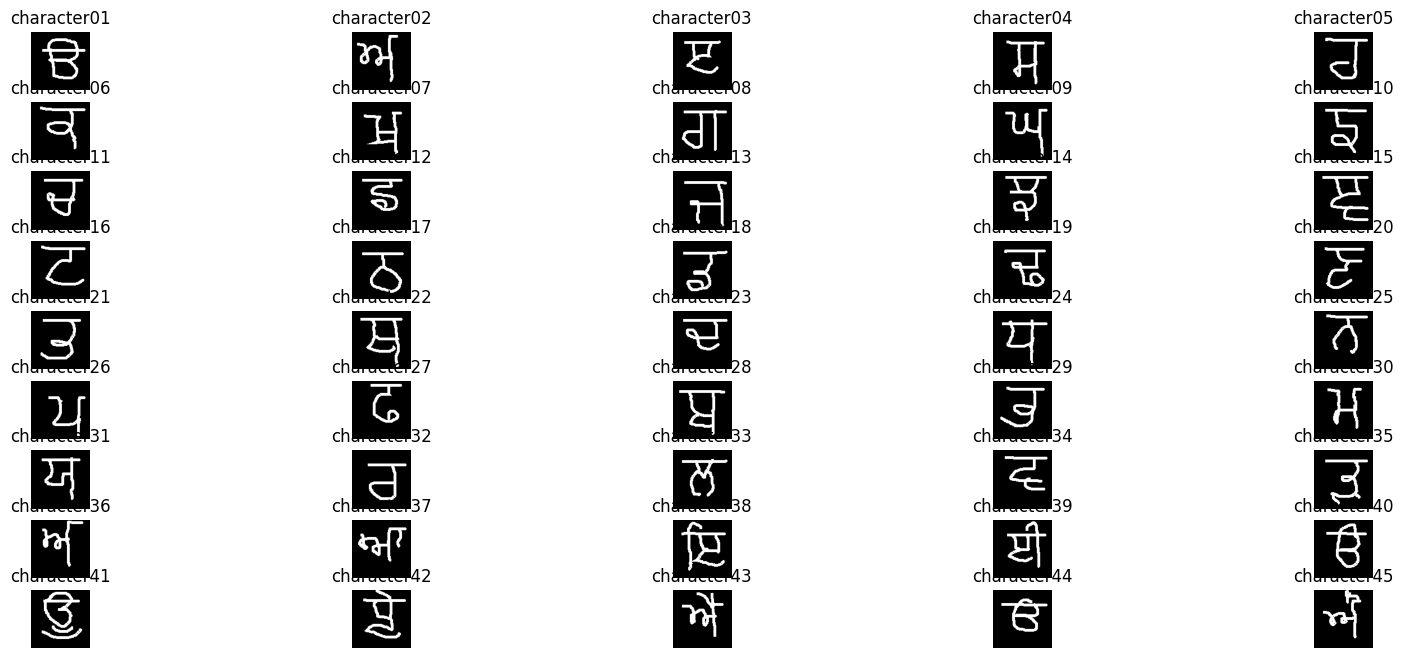

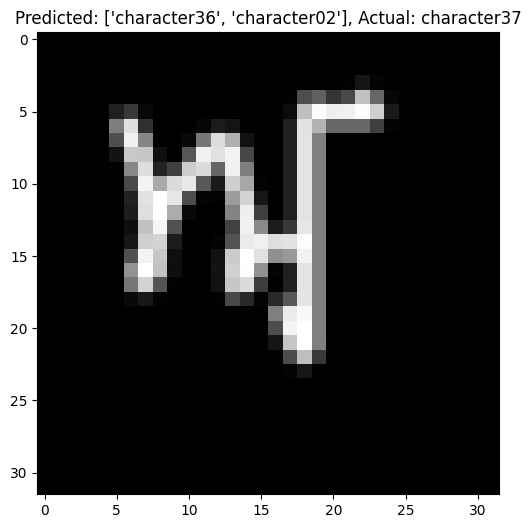

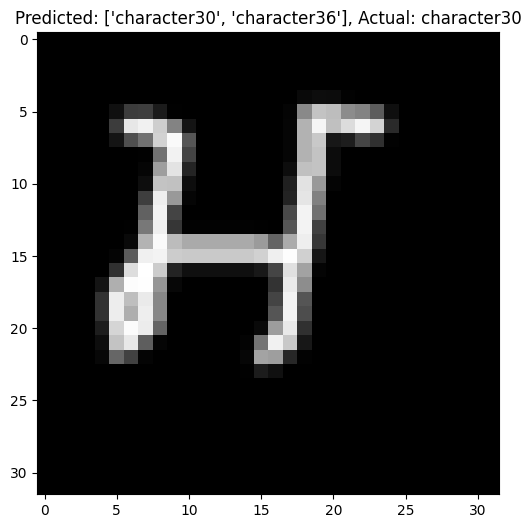

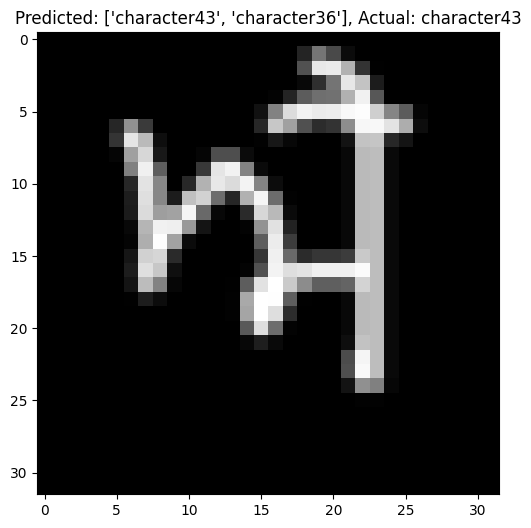

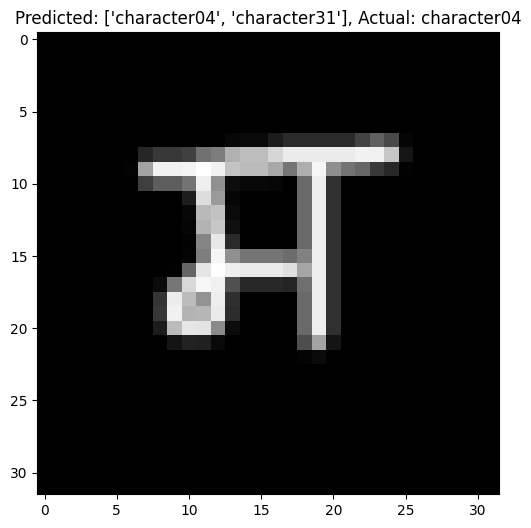

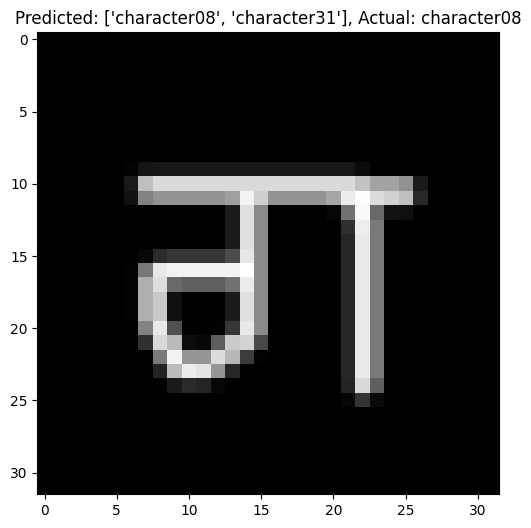

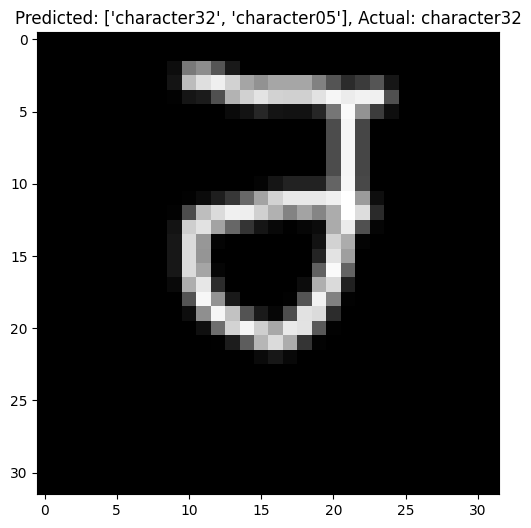

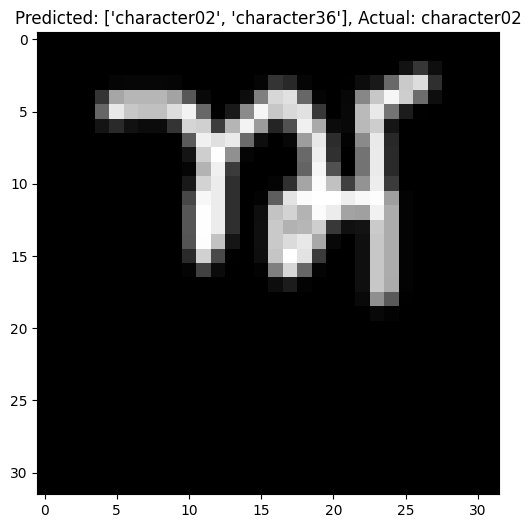

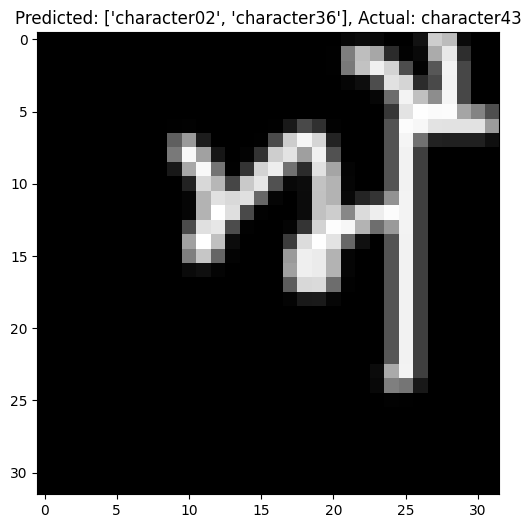

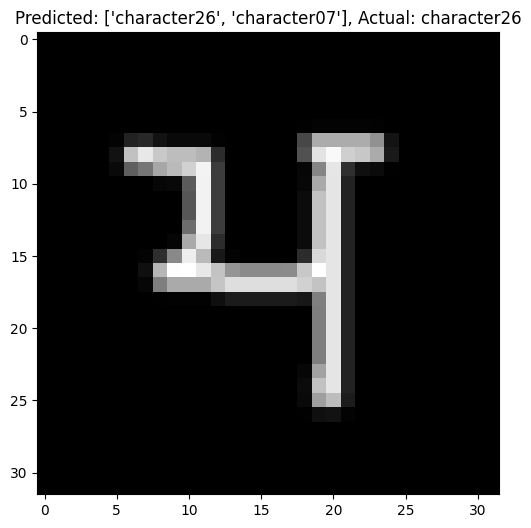

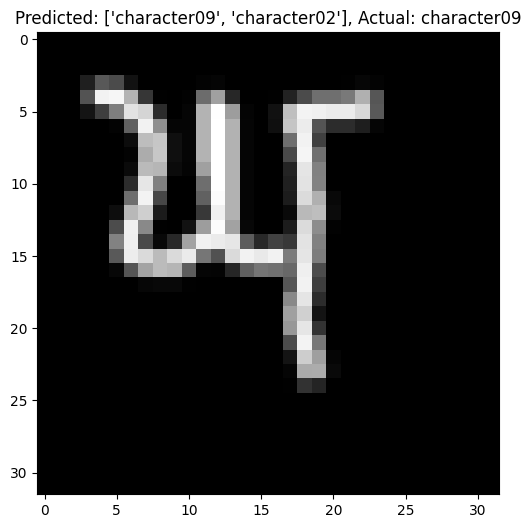

In [31]:
# Plot all the labelled images from a random alphabet in the test data
alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]
alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]

num_images = len(alphabet_annotated)
print(f"Number of images in alphabet {alphabet}: {num_images}")

num_rows = num_images // 5 + (num_images % 5 > 0)  # This will round up to the nearest multiple of 5
num_cols = 5

plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(alphabet_annotated[i].squeeze(0), cmap='gray')
    plt.title(alphabet_annotated_labels[i])
    plt.axis('off')


# Random indexes from the unseen images
random_idx = np.random.choice(len(data_dict_test['unseen_images'][alphabet]), 10)
K = 2
# Plot 10 unseen images from the same alphabet with their predicted labels
for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet][random_idx]):

            # compute embedding for unseen image
            toPILImage = transforms.ToPILImage()
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)
            embedding_unseen = triplet_network.get_embedding(unseen_image.unsqueeze(0).to(DEVICE))

            # list of cosine similarities
            distances = []

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)
                embedding_unnnotated = triplet_network.get_embedding(annotated_image.unsqueeze(0).to(DEVICE))

                distance = (embedding_unseen - embedding_unnnotated).pow(2).sum(1).sqrt()
                distances.append(distance.item())

            # Get the indices of the K smallest distances
            #print(f"distances: {distances}")
            most_similar_indices = np.argsort(distances)[:K]
            #print(f"most similar indices: {most_similar_indices}")
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            #print(f"most similar labels: {most_similar_labels}")

            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][random_idx[i]]
            #print(f"actual label: {actual_label}")

            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(unseen_image.squeeze(0), cmap='gray')
            plt.title(f"Predicted: {most_similar_labels}, Actual: {actual_label}")






# Task 2: rotation problem

In [32]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('data/test_data_task2.pkl')

In [33]:
data_dict_test_task2.keys()

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])

In [35]:
import torch
import torch.nn as nn
from e2cnn.nn import GeometricTensor, R2Conv, FieldType, SequentialModule, InnerBatchNorm, ReLU, PointwiseMaxPool
from e2cnn.gspaces import Rot2dOnR2

class Lambda(nn.Module):
    """
    A utility class that allows you to create a PyTorch nn.Module from an arbitrary function.
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EquivariantEmbeddingNet(nn.Module):
    """
    A PyTorch implementation of a Convolutional Neural Network (CNN) for feature extraction or embedding.

    The network consists of three convolutional blocks each followed by a batch normalization, ReLU activation, and max pooling.
    After the convolutional blocks, the tensor is flattened and passed through two fully connected (linear) layers.

    The final output is a 10-dimensional vector which can be used as an embedding of the input.
    """
    def __init__(self):
        super(EquivariantEmbeddingNet, self).__init__()
        
        # Define the rotation group
        r2_act = Rot2dOnR2(N=8)  # 8 rotations

        # Define field types
        in_type = FieldType(r2_act, [r2_act.trivial_repr])
        out_type_32 = FieldType(r2_act, 32 * [r2_act.regular_repr])
        out_type_64 = FieldType(r2_act, 64 * [r2_act.regular_repr])
        out_type_128 = FieldType(r2_act, 128 * [r2_act.regular_repr])
        out_type_256 = FieldType(r2_act, 256 * [r2_act.regular_repr])

        self.conv_block1 = SequentialModule(
            R2Conv(in_type, out_type_32, kernel_size=3, padding=1),
            InnerBatchNorm(out_type_32),
            ReLU(out_type_32, inplace=True),
            R2Conv(out_type_32, out_type_64, kernel_size=3, padding=1),
            ReLU(out_type_64, inplace=True),
            PointwiseMaxPool(out_type_64, kernel_size=2, stride=2),
        )

        self.conv_block2 = SequentialModule(
            R2Conv(out_type_64, out_type_128, kernel_size=3, padding=1),
            InnerBatchNorm(out_type_128),
            ReLU(out_type_128, inplace=True),
            R2Conv(out_type_128, out_type_128, kernel_size=3, padding=1),
            ReLU(out_type_128, inplace=True),
            PointwiseMaxPool(out_type_128, kernel_size=2, stride=2),
        )

        self.conv_block3 = SequentialModule(
            R2Conv(out_type_128, out_type_256, kernel_size=3, padding=1),
            InnerBatchNorm(out_type_256),
            ReLU(out_type_256, inplace=True),
            R2Conv(out_type_256, out_type_256, kernel_size=3, padding=1),
            ReLU(out_type_256, inplace=True),
            PointwiseMaxPool(out_type_256, kernel_size=2, stride=2),
        )

        self.flatten = Lambda(lambda x: x.tensor.view(x.tensor.size(0), -1))

        self.fc1 = nn.Linear(32768, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        x = GeometricTensor(x, self.conv_block1._modules['0'].in_type)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [36]:
equivariant_triplet_net = TripletNet(EquivariantEmbeddingNet()).to(DEVICE)

In [ ]:
# train the rotation invariant triplet network
if TRAIN_TRIPLET_ROTATION:
    train_triplet_network(equivariant_triplet_net, train_loader, val_loader, num_epochs=1, learning_rate=0.005)
    # Save the trained Siamese network
    torch.save(equivariant_triplet_net.state_dict(), 'rotation_invariant_triplet_network.pth')

In [40]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF

class RotationEquivariantPooling2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, angle_step_size=90):
        super(RotationEquivariantPooling2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding
        self.angle_step_size = angle_step_size

    def forward(self, x):
        # Get the dimensions of the input feature map
        batch_size, channels, height, width = x.size()

        # Pad the input feature map to ensure even dimensions
        padded_height = height + 2 * self.padding
        padded_width = width + 2 * self.padding
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Initialize an empty tensor to store pooled values
        pooled = torch.zeros(batch_size, channels, padded_height // self.stride, padded_width // self.stride, device=x.device)

        # Iterate over rotation angles
        angles = [i*self.angle_step_size for i in range(360 // self.angle_step_size)]
        for angle in angles:
            # Rotate the input feature map
            rotated_x = TF.rotate(x, angle)

            # Perform max pooling on the rotated feature map
            pooled_rotated = F.max_pool2d(rotated_x, kernel_size=self.kernel_size, stride=self.stride)

            # Rotate the pooled values back to the original orientation
            pooled_rotated = TF.rotate(pooled_rotated, -angle)

            # Accumulate the pooled values
            pooled += pooled_rotated

        # Average pooled values across rotations
        pooled /= float(len(angles))

        return pooled

class RotationEquivariantConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, angle_step_size=90):
        super(RotationEquivariantConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.angle_step_size = angle_step_size

    def forward(self, x):
        # Initialize an empty tensor to store the results of each rotation
        batch_size, channels, height, width = x.size()
        out = torch.zeros(batch_size, self.conv.out_channels, height, width, device=x.device)

        # Iterate over rotation angles
        angles = [i*self.angle_step_size for i in range(360 // self.angle_step_size)]
        for angle in angles:
            # Rotate the input
            rotated_x = TF.rotate(x, angle)

            # Apply convolution
            conv_rotated = self.conv(rotated_x)

            # Rotate the result back to the original orientation
            conv_rotated = TF.rotate(conv_rotated, -angle)

            # Accumulate the results
            out += conv_rotated

        # Average the results across rotations
        out /= float(len(angles))

        return out

class RotationInvariantEmbeddingNet(nn.Module):
    """
    A PyTorch implementation of a Convolutional Neural Network (CNN) for feature extraction or embedding.

    The network consists of three convolutional blocks each followed by a batch normalization, ReLU activation, and max pooling.
    After the convolutional blocks, the tensor is flattened and passed through two fully connected (linear) layers.

    The final output is a 10-dimensional vector which can be used as an embedding of the input.
    """
    def __init__(self):
        super(RotationInvariantEmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            RotationEquivariantConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            RotationEquivariantConv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            RotationEquivariantPooling2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            RotationEquivariantConv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            RotationEquivariantConv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            RotationEquivariantPooling2d(kernel_size=2, stride=2),

            # Conv Layer block 3
            RotationEquivariantConv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            RotationEquivariantConv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            RotationEquivariantPooling2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [ ]:
rotation_invariant_triplet_net = TripletNet(RotationInvariantEmbeddingNet()).to(DEVICE)

In [36]:
# train the rotation invariant triplet network
if TRAIN_TRIPLET_ROTATION:
    train_triplet_network(rotation_invariant_triplet_net, train_loader, val_loader, num_epochs=5, learning_rate=0.001)
    # Save the trained Siamese network
    torch.save(rotation_invariant_triplet_net.state_dict(), 'rotation_invariant_triplet_network.pth')

Epoch 1: 100%|██████████| 9158/9158 [1:15:30<00:00,  2.02it/s, loss=0.269, distance=2.15]


Epoch 1, Loss: 0.2687647461282632, Distance: 2.1530347630748397


Val Epoch 1: 100%|██████████| 2290/2290 [12:53<00:00,  2.96it/s, val_loss=0.0885, val_distance=2.63]


Val Epoch 1, Loss: 0.08854213134593057, Distance: 2.625734704186302


Epoch 2: 100%|██████████| 9158/9158 [1:17:16<00:00,  1.98it/s, loss=0.0794, distance=2.72]


Epoch 2, Loss: 0.07937707495840063, Distance: 2.721718172171564


Val Epoch 2: 100%|██████████| 2290/2290 [11:30<00:00,  3.32it/s, val_loss=0.0821, val_distance=3.04]


Val Epoch 2, Loss: 0.08212612784878395, Distance: 3.036619694576513


Epoch 3: 100%|██████████| 9158/9158 [1:21:25<00:00,  1.87it/s, loss=0.056, distance=2.86] 


Epoch 3, Loss: 0.055983353631140154, Distance: 2.8637727989877617


Val Epoch 3: 100%|██████████| 2290/2290 [10:57<00:00,  3.48it/s, val_loss=0.0499, val_distance=3.13]


Val Epoch 3, Loss: 0.0498668700879578, Distance: 3.1335797605556173


Epoch 4: 100%|██████████| 9158/9158 [1:11:51<00:00,  2.12it/s, loss=0.0461, distance=2.97]


Epoch 4, Loss: 0.046083057023866336, Distance: 2.969753101939951


Val Epoch 4: 100%|██████████| 2290/2290 [10:04<00:00,  3.79it/s, val_loss=0.0438, val_distance=3.4] 


Val Epoch 4, Loss: 0.04384339471148351, Distance: 3.403725179105867


Epoch 5: 100%|██████████| 9158/9158 [1:09:17<00:00,  2.20it/s, loss=0.0406, distance=3.05]


Epoch 5, Loss: 0.04055726350811689, Distance: 3.04691497895311


Val Epoch 5: 100%|██████████| 2290/2290 [10:03<00:00,  3.79it/s, val_loss=0.0626, val_distance=2.84]


Val Epoch 5, Loss: 0.06261799744610963, Distance: 2.8381888533263226


In [37]:
# Load the trained rotation invariant triplet network
basic_triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)
basic_triplet_network.load_state_dict(torch.load(main_dir + 'triplet_network_2.pth'))

<All keys matched successfully>

In [43]:
# Evaluate the rotation invariant triplet network
accuracy_1_basic = evaluate_triplet_network(basic_triplet_network, data_dict_test_task2, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_1_basic

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:23<07:34, 23.90s/it]

Accuracy for alphabet Angelic: 0.4631578947368421


 10%|█         | 2/20 [01:02<09:46, 32.57s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.3805668016194332


 15%|█▌        | 3/20 [01:41<10:05, 35.61s/it]

Accuracy for alphabet Atlantean: 0.36639676113360325


 20%|██        | 4/20 [02:21<09:57, 37.36s/it]

Accuracy for alphabet Aurek-Besh: 0.3866396761133603


 25%|██▌       | 5/20 [03:01<09:33, 38.24s/it]

Accuracy for alphabet Avesta: 0.4068825910931174


 30%|███       | 6/20 [03:41<09:05, 38.95s/it]

Accuracy for alphabet Ge_ez: 0.4352226720647773


 35%|███▌      | 7/20 [05:40<14:05, 65.02s/it]

Accuracy for alphabet Glagolitic: 0.3192982456140351


 40%|████      | 8/20 [07:39<16:26, 82.19s/it]

Accuracy for alphabet Gurmukhi: 0.23625730994152047


 45%|████▌     | 9/20 [09:30<16:41, 91.07s/it]

Accuracy for alphabet Kannada: 0.2926829268292683


 50%|█████     | 10/20 [10:32<13:41, 82.16s/it]

Accuracy for alphabet Keble: 0.305668016194332


 55%|█████▌    | 11/20 [13:13<15:56, 106.31s/it]

Accuracy for alphabet Malayalam: 0.3146696528555431


 60%|██████    | 12/20 [15:19<14:58, 112.27s/it]

Accuracy for alphabet Manipuri: 0.32894736842105265


 65%|██████▌   | 13/20 [16:26<11:29, 98.50s/it] 

Accuracy for alphabet Mongolian: 0.41754385964912283


 70%|███████   | 14/20 [19:03<11:36, 116.12s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.36374269005847953


 75%|███████▌  | 15/20 [21:44<10:48, 129.78s/it]

Accuracy for alphabet Oriya: 0.2757437070938215


 80%|████████  | 16/20 [22:48<07:20, 110.12s/it]

Accuracy for alphabet Sylheti: 0.31203007518796994


 85%|████████▌ | 17/20 [23:28<04:26, 88.92s/it] 

Accuracy for alphabet Syriac_(Serto): 0.4416475972540046


 90%|█████████ | 18/20 [24:16<02:33, 76.51s/it]

Accuracy for alphabet Tengwar: 0.3178947368421053


 95%|█████████▌| 19/20 [26:26<01:32, 92.70s/it]

Accuracy for alphabet Tibetan: 0.2794486215538847


100%|██████████| 20/20 [27:17<00:00, 81.90s/it]

Accuracy for alphabet ULOG: 0.4089068825910931


0.3403881479115087

In [41]:
rotation_invariant_triplet_net = TripletNet(RotationInvariantEmbeddingNet()).to(DEVICE)
rotation_invariant_triplet_net.load_state_dict(torch.load(main_dir + 'rotation_invariant_triplet_network.pth'))

<All keys matched successfully>

In [44]:
# Evaluate the rotation invariant triplet network
accuracy_1_rotation = evaluate_triplet_network(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_1_rotation

  5%|▌         | 1/20 [08:28<2:41:09, 508.91s/it]

Accuracy for alphabet Angelic: 0.4473684210526316


 10%|█         | 2/20 [24:32<3:52:58, 776.57s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.41295546558704455


 15%|█▌        | 3/20 [38:42<3:49:28, 809.92s/it]

Accuracy for alphabet Atlantean: 0.37449392712550605


 20%|██        | 4/20 [51:38<3:32:27, 796.73s/it]

Accuracy for alphabet Aurek-Besh: 0.3299595141700405


 25%|██▌       | 5/20 [1:13:32<4:05:45, 983.03s/it]

Accuracy for alphabet Avesta: 0.3866396761133603


 30%|███       | 6/20 [1:38:07<4:28:24, 1150.35s/it]

Accuracy for alphabet Ge_ez: 0.4048582995951417


 30%|███       | 6/20 [4:17:26<10:00:42, 2574.43s/it]


KeyboardInterrupt: 

# Task 3: Domain knowledge injection

In [19]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data(main_dir + 'data/test_data_task3.pkl')
print(data_dict_test_task3.keys())

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


In [20]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same.

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [20]:
len(data_dict_test_task3)

7

In [27]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')


Alphabet: Tengwar
Some character types that preceded unseen images from the Tengwar alphabet: ['II' 'II' 'II' 'II' 'II']
There are 475 preceding character types in the Tengwar alphabet, and 475 unseen images.
Type of character13 from the Tengwar alphabet: I
Probability of a character of type II following a character of type I in the Tengwar alphabet: 0.49583333333333335


In [ ]:
def adjust_probabilities(cnn_probs, preceding_type, type_following_probs, character_to_type_mapping):
    adjusted_probs = cnn_probs.copy()
    for i, prob in enumerate(cnn_probs):
        char_type = character_to_type_mapping[i]
        type_prob = type_following_probs[preceding_type][char_type]
        adjusted_probs[i] *= type_prob
    return adjusted_probs / np.sum(adjusted_probs)

In [ ]:
def predict_with_adjustments(model, unseen_images, unseen_images_preceding_types, type_following_probs, character_to_type_mapping):
    predictions = []
    model.eval()
    with torch.no_grad():
        for img, preceding_type in zip(unseen_images, unseen_images_preceding_types):
            cnn_probs = torch.softmax(model(img.unsqueeze(0)), dim=1).cpu().numpy().flatten()
            adjusted_probs = adjust_probabilities(cnn_probs, preceding_type, type_following_probs, character_to_type_mapping)
            final_prediction = np.argmax(adjusted_probs)
            predictions.append(final_prediction)
    return predictions

In [ ]:
# evaluation method
def evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=True, device=DEVICE) -> float:
    """
    This function evaluates the Triplet network on the test data
    :param triplet_network: the trained Triplet network
    :param data_dict_test: the test data dictionary with the keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'
    :param K: the number of most similar images to consider
    """
    triplet_network.eval()
    correct_predictions = 0
    num_images = 0

    # Transform images
    toPILImage = transforms.ToPILImage()

    for alphabet in tqdm(data_dict_test['annotated_images'].keys()):

        correct_predictions_alphabet = 0

        for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet]):

            # compute embedding for unseen image
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)
            embedding_unseen = triplet_network.get_embedding(unseen_image.unsqueeze(0).to(device))

            # list of cosine similarities
            distances = []

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)
                embedding_unnnotated = triplet_network.get_embedding(annotated_image.unsqueeze(0).to(device))

                distance = (embedding_unseen - embedding_unnnotated).pow(2).sum(1).sqrt()
                distances.append(distance.item())

            # Get the indices of the K smallest distances
            #print(f"distances: {distances}")
            most_similar_indices = np.argsort(distances)[:K]
            #print(f"most similar indices: {most_similar_indices}")
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            #print(f"most similar labels: {most_similar_labels}")

            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][i]
            #print(f"actual label: {actual_label}")

            if actual_label in most_similar_labels:
                correct_predictions += 1
                correct_predictions_alphabet += 1
            num_images += 1

        accuracy_alphabet = correct_predictions_alphabet / len(data_dict_test['unseen_images'][alphabet])
        if print_alphabet_accuracy:
            print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet}")

    # Compute the accuracy
    accuracy = correct_predictions / num_images
    return accuracy


In [ ]:
predictions = predict_with_adjustments(model, unseen_images, unseen_images_preceding_types, type_following_probs, character_to_type_mapping)

evaluate_triplet_network(basic_triplet_networks, data_dict_test_task3, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)